#**TERM PAPER - PROJECT (IT-550)**#
##**Title of Paper:**##
Automatic Text Summarization : A Comprehensive Survey
##**Team members:**
Sana Baid : 202011019

Shivangi Gajjar : 202011023

Shradha Makhija : 202011029

Mantra Sanathra : 202011041

E.V.V. Hari Charan : 202011056



#**Import Libraries** 

In [ ]:
!pip install rouge-score

In [ ]:
from csv import DictWriter
import ast
import json
import csv
import operator
import re
import os
import math
from numba import jit
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
from nltk.tokenize import sent_tokenize
from scipy.spatial import distance as cos_dist
import numpy as np
from numpy.linalg import norm
from gensim.models import Word2Vec
from scipy.spatial import distance as cos_dist
from sklearn.feature_extraction.text import TfidfVectorizer 
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import warnings 
import urllib
import requests
from sklearn.metrics.pairwise import cosine_similarity
from rouge_score import rouge_scorer
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

#**Reading Data Set**

In [ ]:
url = "https://raw.githubusercontent.com/abisee/cnn-dailymail/master/url_lists/all_train.txt"
file = urllib.request.urlopen(url)
temp = []
for line in file:
  temp.append(line.decode("utf-8"))

#**Preparing Corpus**

In [ ]:
corpus = []
ref_summary = []
link_list = temp[:500]

for link in link_list:
  page = requests.get(link)
  html = page.content

  ## creating BeautifulSoup object
  soup = BeautifulSoup(html)
  temp1 = soup.find("div", {"id": "cnnTxtCmpnt"})  
  paras = temp1.find_all("p")

  text = ""
  for para in paras[:-1]:
    text += str(para.get_text()) + " "
  
  flag = 0 #to check if the text is empty
  if text != "":
    flag = 1
    corpus.append(text)

  temp2 = soup.find("div", {"id": "cnnHeaderRightCol"})
  summary = temp2.find("ul") 
  sent_list = summary.find_all("li")
  
  text = []

  # first and last sentence removed as they contain heading and footnote
  for sent in sent_list[1:-1]:
    text.append(sent.get_text())

  if flag != 0:
    ref_summary.append(text)

#**Preprocessing function**

In [ ]:
def pre_process(data):
  data = re.sub('[^\w\s]',"",data)             # punctuation removal
  data = re.sub('[0-9]',"",data)               # number removal
  data = data.lower()                          # lowercasing
  data = data.split()
  sw = stopwords.words('english')
  wl = WordNetLemmatizer()                     # lemmatization
  data = [wl.lemmatize(token) for token in data if token not in sw] #stop words removal
  data = ' '.join(data)
  data = data.strip(' ')                
  return data

In [ ]:
data = []
raw_corpus = []

#Tokenisation and calling preprocessing function
for item in corpus:
  sent = sent_tokenize(item)
  raw_corpus.append(sent)
  sent = [pre_process(i) for i in sent]
  data.append(sent)


#**TF-IDF Vectorizing**

In [ ]:
#Creating list of all the words for each document
TF_IDF_DOCS = []
for doc in data:
  vectorizer = TfidfVectorizer()
  try:
    TF_IDF_DOCS.append(vectorizer.fit_transform(doc)) #tf-idf vector for each sentence in doc
  except:
    print(data.index(doc))

#**Word2Vec Vectorizing** 

In [ ]:
#Creating list of all the words for each document
sg_data = []
for doc in data:
  tokens = []
  for sent in doc:
    tokens.extend(sent.split())
  sg_data.append(tokens)

In [ ]:
# Training Word2Vec model using Skip-Gram
sg_model = Word2Vec(sg_data, size = 150, min_count = 1,window = 10, sg = 1, hs = 1, iter = 5, workers = 10)


## Document vectorisation

In [ ]:

# Calculating weighted average and forming document vectors
WORD2VEC_DOCS = []
for doc in data:
  doc_vec = []
  for sent in doc:
      temp1 = np.zeros(150)
      for word in sent.split():
          try:
              temp1 = temp1 + sg_model.wv.__getitem__(word) # adding values of each token in doc to vector
          except:
            continue
      doc_vec.append(temp1/len(sent.split()))
  WORD2VEC_DOCS.append(doc_vec)    

#**Clustering using K-means**

In [ ]:
def my_Kmeans(data_arr,k,max_iter):

  centroids = dict()      # to save centroids ({class_label : centroid})
  classes = dict()        # to save data per class ({class_label : [list of data]})
  predict = dict()        # to save data index per class  ({class_label:[indices of data]})

  # Initializing the centroids as first k data points 
  for i in range(k):
      centroids[i] = data_arr[i]

  # Iterations 
  for iter in range(max_iter):
      classes = dict()
      predict = dict()
      for i in range(k):
          classes[i] = []
          predict[i] = []
      ctr = 0

      # Calculating distance and finding minimum distance
      for data in data_arr:
          distance = []
          for c in centroids:
              distance.append(cos_dist.cosine(data, centroids[c]))    # distance computation
          index_point = distance.index(min(distance))
          classes[index_point].append(data)
          predict[index_point].append(ctr)
          ctr = ctr + 1
      old = dict(centroids)      # saving old centroids for error checking

      # replacing centroid as new mean of datapoints
      for i in classes:
          new_centroid = np.mean(classes[i], axis = 0)
          centroids[i] = new_centroid
      
      # checking error (here set as 0.001)
      break_loop = 1
      for c in old:
          old_centroid = old[c]
          current_centroid = centroids[c]
          if np.sum((current_centroid - old_centroid)/old_centroid *100) > 0.001:
              break_loop = 0
      if break_loop == 1:             
          break

  # making a prediction list for all data-points        
  prediction = list(np.zeros(len(data_arr)))
  for j in predict:
      for p in predict[j]:
          prediction[p] = j
          
  return centroids,classes, prediction

#**Summarization**


In [ ]:
#Summary generation for documents
#returns sorted indices of the summary sentence vectors 
def get_summary(data_arr,k,max_iter):
  summary = []
  centroids, classes,custom = my_Kmeans(data_arr,k,max_iter)

  #custom -> contains cluster labels
  #Check to consider only those docs that have created k distinct clusters
  if len(set(custom)) == k:
    for k in centroids:
      centroid_list = []

      #Fetching the distance of the cluster sentences to the cluster's centroid
      for line in classes[k]:
        centroid_list.append(cos_dist.cosine(line , centroids[k][0]))

      #selecting closest sentence for summary
      sent_index = classes[k][np.argmin(centroid_list)] #index of of the closest sentence
      summary.append(list(np.where(np.all(data_arr == sent_index,axis=1)))[0][0])

    #list of the indices of the summary sentences
    summary = sorted(summary)

  return summary

In [ ]:
#Summarizer function for TF-IDF vectorised documents
def summarizer_TF(sent_count):
  new_summary = []
  #outliers = 0
  for i in range(len(TF_IDF_DOCS)):
      if len(data[i]) >sent_count :
        summary = get_summary(TF_IDF_DOCS[i].todense(), sent_count,max_iter=20)

        temp_summary = []
        for ind in summary:
          #fetching sentence from raw corpus i.e original sentence
          temp_summary.append(raw_corpus[i][ind])

        new_summary.append(temp_summary)
      else:
        new_summary.append(raw_corpus[i]) 
  return new_summary

In [ ]:
#Summarizer function for word to vector vectorised documents
def summarizer_W2V(sent_count):
  new_summary = []
  #outliers = 0
  for i in range(len(WORD2VEC_DOCS)):
      if len(data[i]) > sent_count :
        summary = get_summary(np.array(WORD2VEC_DOCS[i]),sent_count,max_iter=20)
      
        temp_summary = []
        for ind in summary:
          #fetching sentence from raw corpus i.e original sentence
          temp_summary.append(raw_corpus[i][ind])

        new_summary.append(temp_summary)
      else:
        new_summary.append(raw_corpus[i]) 
  return new_summary

##Sample summary display

In [ ]:
print("Text Data: ")
for i in raw_corpus[0]:
  print(i)

print("\nOriginal Summary: ")
for i in ref_summary[0]:
  print(i)

Text Data: 
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."
Here, inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court.
Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies."
He says the arrests often result from confrontations with police.
Mentally ill people often won't do what they're told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less likely t

In [ ]:
sample_summary_TF = summarizer_TF(7)

In [ ]:
print("\nSummary generated (TF-IDF): ")
for i in sample_summary_TF[0]:
  print(i)


Summary generated: 
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."
Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies."
He says the arrests often result from confrontations with police.
Mentally ill people often won't do what they're told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less likely to follow directions, according to Leifman.
Leifman says about one-third of all people in Miami-Dade county jails are mentally ill.
Leifman says in 1955 there were more than half a million people in state mental hospitals, and today that number has been reduced 90 percent, and 40,000 to 50,000 people are in mental hospitals.
The patients win, the families are relieved, and the state saves money by simply not cycling these prisoners through again and

In [ ]:
sample_summary_W2V = summarizer_W2V(7)

In [ ]:
print("\nSummary generated(Word2Vec): ")
for i in sample_summary_W2V[0]:
  print(i)


Summary generated(Word2Vec): 
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."
He says the arrests often result from confrontations with police.
He is well known in Miami as an advocate for justice and the mentally ill.
It's brutally unjust, in his mind, and he has become a strong advocate for changing things in Miami.
Over the years, he says, there was some public outcry, and the mentally ill were moved out of jails and into hospitals.
The streets.
E-mail to a friend


#**Evaluation** 

##Rouge1

In [ ]:
#Returns Average precision, f-measre and recal of rouque 1
def get_rouge1(new_summary,doc_len):
  avgp = 0
  avgr = 0
  avgf = 0

  for i in range(len(new_summary)):
    scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
    scores = scorer.score(str(new_summary[i]),str(ref_summary[i]))

    avgp += scores["rouge1"].precision
    avgr += scores["rouge1"].recall
    avgf += scores["rouge1"].fmeasure



  return avgp/doc_len,avgr/doc_len,avgf/doc_len


Rougue 1 calculation for tfidf

In [ ]:
sent_count = np.arange(5,20,2)
#Getting ROUGE1
scores_tfidf_p = []
scores_tfidf_r = []
scores_tfidf_f = []

for count in sent_count:
  summary = summarizer_TF(count) 
  score,r,f = get_rouge1(summary,len(data))
  scores_tfidf_p.append(score)
  scores_tfidf_r.append(r)
  scores_tfidf_f.append(f)


In [ ]:
#TFidf
print("r1 score(p):\n", [round(x,4) for x in scores_tfidf_p])
print("r1 score(r):\n", [round(x,4) for x in scores_tfidf_r])
print("r1 score(f):\n", [round(x,4) for x in scores_tfidf_f])

r1 score(p):
 [0.5319, 0.6093, 0.6572, 0.6972, 0.7178, 0.7423, 0.7523, 0.7641]
r1 score(r):
 [0.2068, 0.1699, 0.1441, 0.127, 0.1133, 0.1049, 0.0977, 0.0923]
r1 score(f):
 [0.291, 0.2612, 0.2328, 0.2118, 0.1929, 0.1811, 0.1703, 0.162]


Rouge1 calculation for word2vec

In [ ]:
scores_w2v_p = []
scores_w2v_r = []
scores_w2v_f = []

for count in sent_count:
  summary = summarizer_W2V(count) 
  p,r,f = get_rouge1(summary,len(data))
  scores_w2v_p.append(p)
  scores_w2v_r.append(r)
  scores_w2v_f.append(f)

In [ ]:
#W2V
print("r1 score(p):\n", [round(x,4) for x in scores_w2v_p])
print("r1 score(r):\n", [round(x,4) for x in scores_w2v_r])
print("r1 score(f):\n", [round(x,4) for x in scores_w2v_f])

r1 score(p):
 [0.3928, 0.4849, 0.5441, 0.6033, 0.6451, 0.6804, 0.7045, 0.7214]
r1 score(r):
 [0.1722, 0.1507, 0.1314, 0.1195, 0.1089, 0.1019, 0.0957, 0.0907]
r1 score(f):
 [0.2339, 0.2254, 0.2082, 0.1965, 0.1837, 0.1747, 0.166, 0.1585]


Comparison between tf-idf and word2vec metrics

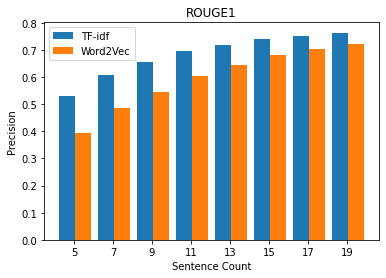

In [ ]:
plt.bar(sent_count-0.35,scores_tfidf_p,label="TF-idf")
plt.bar(sent_count+0.45,scores_w2v_p,label="Word2Vec")
plt.xticks(sent_count)
plt.legend()
plt.title("ROUGE1")
plt.xlabel("Sentence Count")
plt.ylabel("Precision")
plt.show()

##Rouge2

In [ ]:
#Returns Average precision, f-measre and recal of rouque 2
def get_rouge2(new_summary,doc_len):
  avgp = 0
  avgr = 0
  avgf = 0

  for i in range(len(new_summary)):
    scorer = rouge_scorer.RougeScorer(['rouge2'], use_stemmer=True)
    scores = scorer.score(str(new_summary[i]),str(ref_summary[i]))

    avgp += scores["rouge2"].precision
    avgr += scores["rouge2"].recall
    avgf += scores["rouge2"].fmeasure



  return avgp/doc_len,avgr/doc_len,avgf/doc_len


Rouge 2 calculation for tf-idf 

In [ ]:

r2_tfidf_p = []
r2_tfidf_r = []
r2_tfidf_f = []

for count in sent_count:
  summary = summarizer_TF(count) 
  score,r,f = get_rouge2(summary,len(data))
  r2_tfidf_p.append(score)
  r2_tfidf_r.append(r)
  r2_tfidf_f.append(f)


In [ ]:
#TFidf
print("r2 score(p):\n", [round(x,4) for x in r2_tfidf_p])
print("r2 score(r):\n", [round(x,4) for x in r2_tfidf_r])
print("r2 score(f):\n", [round(x,4) for x in r2_tfidf_f])

r2 score(p):
 [0.2019, 0.2464, 0.2754, 0.3007, 0.3159, 0.3366, 0.3463, 0.3586]
r2 score(r):
 [0.0761, 0.0664, 0.0586, 0.0533, 0.0491, 0.0472, 0.0449, 0.0436]
r2 score(f):
 [0.1082, 0.103, 0.0954, 0.0895, 0.0839, 0.0818, 0.0785, 0.0765]


Rouge2 calculation for word2vec

In [ ]:
r2_w2v_p = []
r2_w2v_r = []
r2_w2v_f = []

for count in sent_count:
  summary = summarizer_W2V(count) 
  p,r,f = get_rouge2(summary,len(data))
  r2_w2v_p.append(p)
  r2_w2v_r.append(r)
  r2_w2v_f.append(f)

In [ ]:
#W2V
print("r2 score(p):\n", [round(x,4) for x in r2_w2v_p])
print("r2 score(r):\n", [round(x,4) for x in r2_w2v_r])
print("r2 score(f):\n", [round(x,4) for x in r2_w2v_f])

r2 score(p):
 [0.1208, 0.1648, 0.2019, 0.2398, 0.2654, 0.2931, 0.3148, 0.33]
r2 score(r):
 [0.0512, 0.0494, 0.0469, 0.0459, 0.0437, 0.0434, 0.0425, 0.0416]
r2 score(f):
 [0.0703, 0.0746, 0.0751, 0.076, 0.0742, 0.0747, 0.074, 0.0728]


Comparison between tf-idf and word2vec metrics

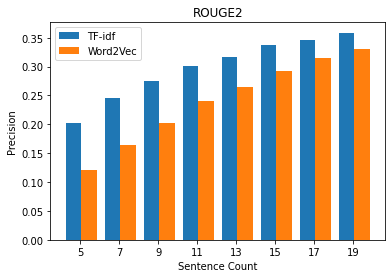

In [ ]:
plt.bar(sent_count-0.35,r2_tfidf_p,label="TF-idf")
plt.bar(sent_count+0.45,r2_w2v_p,label="Word2Vec")
plt.xticks(sent_count)
plt.legend()
plt.xlabel("Sentence Count")
plt.ylabel("Precision")
plt.title("ROUGE2")
plt.show()